Enter percent light in surround (0-100):  100
Enter percent light in center (0-100):  0


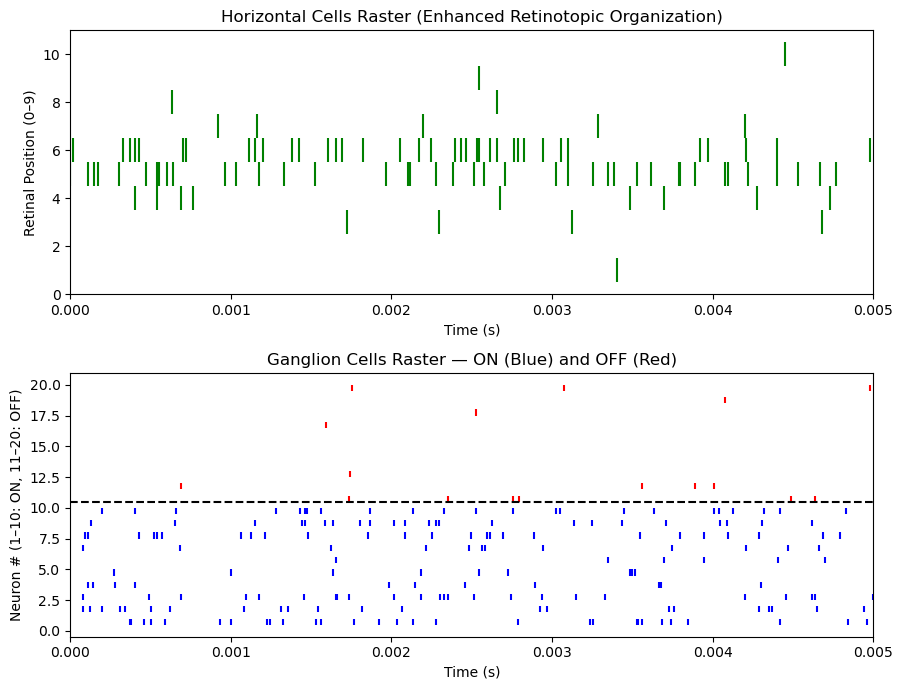


--- INPUT SUMMARY ---
Center light: 0.0%
Surround light: 100.0%

--- MEAN FIRING RATES (spikes/ms) ---
Horizontal avg: 22.65
ON-center avg: 38.70
OFF-center avg: 3.58


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# === USER INPUT ===
surround_light = float(input("Enter percent light in surround (0-100): ")) / 100
center_light = float(input("Enter percent light in center (0-100): ")) / 100

# === MODEL PARAMETERS ===
num_horizontal = 10
num_ganglion_on = 10
num_ganglion_off = 10
duration_ms = 5
steps = 500
time = np.linspace(0, duration_ms / 1000, steps)
basal_rate = 5  # spikes/ms baseline

# === DEFINE RETINAL LAYOUT ===
neurons = np.arange(num_horizontal)
center_idx = np.arange(4, 6)
surround_idx = np.setdiff1d(neurons, center_idx)

# === PHOTORECEPTOR INPUTS (before inhibition) ===
photoreceptors = np.ones(num_horizontal) * (1 - surround_light)
photoreceptors[center_idx] = 1 - center_light

# === HORIZONTAL CELLS (compute local input from photoreceptors) ===
horizontal = np.zeros(num_horizontal)
for i in range(num_horizontal):
    left = max(0, i - 1)
    right = min(num_horizontal - 1, i + 1)
    horizontal[i] = np.mean(photoreceptors[left:right + 1])

# Normalize and apply nonlinear gain
horizontal_normalized = (horizontal - np.min(horizontal)) / (np.ptp(horizontal) + 1e-9)
horizontal_firing = basal_rate + horizontal_normalized**2.5 * basal_rate * 15  # amplified contrast

# === APPLY INHIBITION FROM HORIZONTAL CELLS TO PHOTORECEPTORS ===
inhibited_photoreceptors = photoreceptors.copy()
for i in range(num_horizontal):
    inhibition_strength = horizontal_firing[i] / (basal_rate * 20)  # normalize to ~0–1
    for offset in [-1, 1]:
        target = i + offset
        if 0 <= target < num_horizontal:
            inhibited_photoreceptors[target] -= inhibition_strength
            inhibited_photoreceptors[target] = np.clip(inhibited_photoreceptors[target], 0, 1)

# === GANGLION CELLS (ON and OFF) with lateral inhibition from horizontal cells ===
on_center = np.zeros(num_ganglion_on)
off_center = np.zeros(num_ganglion_off)

for i in range(num_ganglion_on):
    # Determine light input from inhibited photoreceptors
    light_input = 1 - inhibited_photoreceptors[i]

    # Estimate local horizontal inhibition (from neighboring horizontal cells)
    local_inhibition = 0
    if i - 1 >= 0:
        local_inhibition += horizontal_firing[i - 1]
    if i + 1 < num_horizontal:
        local_inhibition += horizontal_firing[i + 1]
    local_inhibition /= (basal_rate * 30)  # normalized

    # Final ganglion cell firing rate with inhibition applied
    on_center[i] = basal_rate * (1 + light_input * 10) * (1 - local_inhibition)
    off_center[i] = basal_rate * (1 + (1 - light_input) * 10) * (1 - local_inhibition)

    # Clip to non-negative
    on_center[i] = max(0, on_center[i])
    off_center[i] = max(0, off_center[i])

# === SPIKE GENERATION ===
def make_spikes(firing_rates, t):
    spikes = []
    for fr in firing_rates:
        prob = fr / 1000
        spike_times = t[np.random.rand(len(t)) < prob]
        spikes.append(spike_times)
    return spikes

h_spikes = make_spikes(horizontal_firing, time)
on_spikes = make_spikes(on_center, time)
off_spikes = make_spikes(off_center, time)

# === PLOTTING ===
fig, axs = plt.subplots(2, 1, figsize=(9, 7))

# 1️⃣ Horizontal Cells — Enhanced Retinotopy
for i, spike_times in enumerate(h_spikes):
    axs[0].vlines(spike_times, i + 0.5, i + 1.5, color='green')
axs[0].set_title("Horizontal Cells Raster (Enhanced Retinotopic Organization)")
axs[0].set_xlim(0, 0.005)
axs[0].set_ylabel("Retinal Position (0–9)")
axs[0].set_xlabel("Time (s)")

# 2️⃣ Ganglion Cells — ON (Blue) and OFF (Red)
for i, spike_times in enumerate(on_spikes):
    axs[1].vlines(spike_times, i + 0.5, i + 1, color='blue')  # ON-center
for i, spike_times in enumerate(off_spikes):
    axs[1].vlines(spike_times, i + 10.5, i + 11, color='red')  # OFF-center

axs[1].axhline(10.5, color='k', linestyle='--')
axs[1].set_title("Ganglion Cells Raster — ON (Blue) and OFF (Red)")
axs[1].set_xlim(0, 0.005)
axs[1].set_ylabel("Neuron # (1–10: ON, 11–20: OFF)")
axs[1].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

# === SUMMARY OUTPUT ===
print("\n--- INPUT SUMMARY ---")
print(f"Center light: {center_light*100:.1f}%")
print(f"Surround light: {surround_light*100:.1f}%")

print("\n--- MEAN FIRING RATES (spikes/ms) ---")
print(f"Horizontal avg: {np.mean(horizontal_firing):.2f}")
print(f"ON-center avg: {np.mean(on_center):.2f}")
print(f"OFF-center avg: {np.mean(off_center):.2f}")
